In [1]:
import os
from tqdm import tqdm
from timeit import default_timer as timer  
import time

inf=float("inf")
import numpy as np
import pandas as pd

from dtw import *

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import stablerank.srank as sr
import fMRIanalysis.data as data

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit

import pickle

from scipy.interpolate import interp1d
from scipy.spatial import distance

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
med_info = pd.read_excel(r'data/Medicineinfo.xlsx').iloc[:,1].to_numpy()
med_indices = np.where(med_info == 1)[0]

range_of_subjects = range(1, 107)

colors = dict()
labels = dict()
counts = np.zeros(5)
i_ctr = []
i_pd_cn_med = []
i_pd_cn_nonmed = []
i_pd_mci_med = []
i_pd_mci_nonmed = []

for subject in range_of_subjects:
    if subject < 16:
        label = "CTR"
        color = 'k'
        counts[0] += 1
        i_ctr.append(subject)
    elif (subject >= 16 and subject < 88):
        if subject in med_indices:
            label = "PD_CN_med"
            color = 'y'
            counts[1] += 1
            i_pd_cn_med.append(subject)
        else:
            label = "PD_CN_nonMed"
            color = 'g'
            counts[2] += 1
            i_pd_cn_nonmed.append(subject)
    else:
        if subject in med_indices:
            label = "PD_MCI_med"
            color = 'r'
            counts[3] += 1
            i_pd_mci_med.append(subject)
        else:
            label = "PD_MCI_nonMed"
            color = 'm'
            counts[4] += 1
            i_pd_mci_nonmed.append(subject)
    labels[subject] = label
    colors[subject] = color
    
counts = [int(count) for count in counts]

In [3]:
range_of_subjects = range(1, 107)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=5)
split = sss.split([subject for subject in range_of_subjects], [labels[subject] for i in range_of_subjects])
train_index, val_index = next(iter(split))
train_subjects = train_index + 1
val_subjects = val_index + 1

train_counts = []
val_counts = []
for label in ['CTR', 'PD_CN_med', 'PD_CN_nonMed', 'PD_MCI_med', 'PD_MCI_nonMed']:
    train_counts.append([labels[subject] for subject in train_subjects].count(label))
    val_counts.append([labels[subject] for subject in val_subjects].count(label))
print(counts)
print(train_counts)
print(val_counts)

train_i_ctr = list(set(i_ctr).intersection(set(train_subjects)))
train_i_pd_cn_med = list(set(i_pd_cn_med).intersection(set(train_subjects)))
train_i_pd_cn_nonmed = list(set(i_pd_cn_nonmed).intersection(set(train_subjects)))
train_i_pd_mci_med = list(set(i_pd_mci_med).intersection(set(train_subjects)))
train_i_pd_mci_nonmed = list(set(i_pd_mci_nonmed).intersection(set(train_subjects)))

[15, 51, 21, 10, 9]
[7, 31, 15, 5, 5]
[8, 20, 6, 5, 4]


In [4]:
methods = ["delayedPearson\\C200_delay"+str(i) for i in range(1,4)] 
methods = methods + ["filtered_delayedPearson\\FDP_delay"+str(i) for i in range(4)]
methods = methods + ["dtw", "filtered_dtw"]

neg_vals_methods = ["abs", "clip_zero", "clip_zero_inv"]
symmetrizations = ["upper", "lower", "maximum", "minimum", "symmetric_part", "antisymmetric_part", "transpose_multiplication", "pdist_rows", "pdist_columns"]

homologies = ["H0_single", "H0_complete", "H0_average", "H1"]

In [5]:
def f_global(method, neg_vals_method, symmetrization, homology, sample_size = 50, number_instances = 50):
    sample = sr.get_sample(number_instances = number_instances, sample_size = sample_size, probabilities = 200)

    hsr_subjects = dict()

    for subject in train_subjects:
        dist_mat = data.DistanceMatrix(subject = subject, 
                                       method = method, 
                                       neg_vals_method = neg_vals_method, 
                                       symmetrization = symmetrization).dist_mat
        d = sr.Distance(dist_mat)

        if "H0" in homology:
            clustering_method = homology.split("_")[1]
            hsr_subjects[subject] = d.get_h0sr(sample=sample, clustering_method=clustering_method)
        else:
            barcode = d.get_bc(sample=sample, maxdim=1, thresh=inf, coeff=2)
            hsr_subjects[subject] = sr.bc_to_sr(barcode, degree = "H1")

    return hsr_subjects

In [70]:
sample_size = 50 
number_instances = 50 
method = "filtered_dtw"
neg_vals_method = None
symmetrization = None
homology = "H0_complete"

hsr_subjects = f_global(method, neg_vals_method, symmetrization, homology, sample_size, number_instances)
hsr_subjects_H1 = f_global(method, neg_vals_method, symmetrization, "H1", sample_size, number_instances)

In [51]:
total = sr.Pcnif([[0,0], [0,0]])
for subject, stableR in hsr_subjects.items():
    total = total.__add__(stableR)
total = total / sum(train_counts)

In [52]:
total_ctr = sr.Pcnif([[0,0], [0,0]])
for subject in train_i_ctr:
    total_ctr = total_ctr.__add__(hsr_subjects[subject])
total_ctr = total_ctr / len(train_i_ctr)

In [53]:
maxVal = 0
for subject, stableR in hsr_subjects.items():
    tempVal = stableR.evaluate(0.4)
    if tempVal > maxVal:
        maxVal = tempVal
        maxId = subject
max_sr = hsr_subjects[maxId]

In [54]:
maxVal = 0
for subject in train_i_ctr:
    tempVal = hsr_subjects[subject].evaluate(0.4)
    if tempVal > maxVal:
        maxVal = tempVal
        maxId = subject
max_sr_ctr = hsr_subjects[maxId]

In [55]:
minVal = 100
for subject in train_i_ctr:
    tempVal = hsr_subjects[subject].evaluate(0.4)
    if tempVal < minVal:
        minVal = tempVal
        minId = subject
min_sr_ctr = hsr_subjects[minId]

In [56]:
#ref = total
#ref = total_ctr
#ref = max_sr
ref = max_sr_ctr
#ref = min_sr_ctr

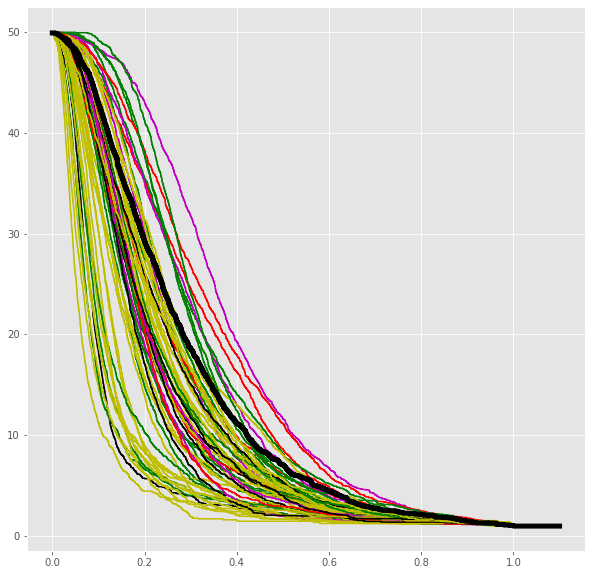

In [57]:
plt.figure(figsize=(10, 10))
for subject, stableR in hsr_subjects.items():
    stableR.plot(color = colors[subject])
ref.plot(linewidth = 5, color = 'k')
plt.show()

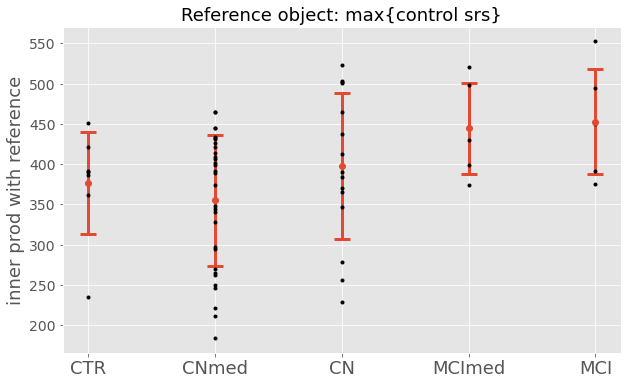

In [66]:
start = 0
end = 1

innerProd = dict()
ip_ctr = []
ip_pd_cn_med = []
ip_pd_cn_nonMed = []
ip_pd_mci_med = []
ip_pd_mci_nonMed = []

for subject, stableR in hsr_subjects.items():
    innerProd[subject] = stableR.dot(ref, start, end)

    if labels[subject] == "CTR":
        ip_ctr.append(innerProd[subject])
    if labels[subject] == "PD_CN_med":
        ip_pd_cn_med.append(innerProd[subject])
    if labels[subject] == "PD_CN_nonMed":
        ip_pd_cn_nonMed.append(innerProd[subject])
    if labels[subject] == "PD_MCI_med":
        ip_pd_mci_med.append(innerProd[subject])
    if labels[subject] == "PD_MCI_nonMed":
        ip_pd_mci_nonMed.append(innerProd[subject])

class_means = [np.mean(np.array(ip_ctr)), np.mean(np.array(ip_pd_cn_med)), np.mean(np.array(ip_pd_cn_nonMed)), 
               np.mean(np.array(ip_pd_mci_med)), np.mean(np.array(ip_pd_mci_nonMed))]
class_stds = [np.std(np.array(ip_ctr)), np.std(np.array(ip_pd_cn_med)), np.mean(np.std(ip_pd_cn_nonMed)), 
               np.std(np.array(ip_pd_mci_med)), np.std(np.array(ip_pd_mci_nonMed))]

plt.figure(figsize=(10, 6))
plt.errorbar(x = [1, 2, 3, 4, 5], y = class_means, yerr = class_stds, fmt = "o", markersize = 6, capsize = 8, capthick = 3, elinewidth = 3)
plt.plot([1 for i in range(len(ip_ctr))], ip_ctr, ".k")
plt.plot([2 for i in range(len(ip_pd_cn_med))], ip_pd_cn_med, ".k")
plt.plot([3 for i in range(len(ip_pd_cn_nonMed))], ip_pd_cn_nonMed, ".k")
plt.plot([4 for i in range(len(ip_pd_mci_med))], ip_pd_mci_med, ".k")
plt.plot([5 for i in range(len(ip_pd_mci_nonMed))], ip_pd_mci_nonMed, ".k")
plt.xticks([1, 2, 3, 4, 5], ["CTR", "CNmed", "CN", "MCImed", "MCI"], fontsize = 18)
plt.yticks(fontsize = 14)
plt.ylabel("inner prod with reference", fontsize = 18)
plt.title("Reference object: max{control srs}", fontsize = 18)
plt.show()
plt.close()

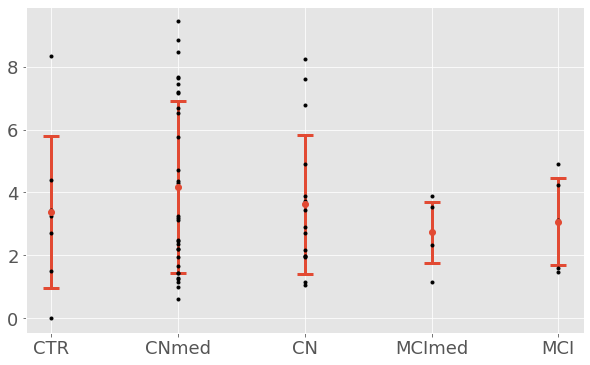

In [46]:
start = 0
end = 1

innerProd = dict()
ip_ctr = []
ip_pd_cn_med = []
ip_pd_cn_nonMed = []
ip_pd_mci_med = []
ip_pd_mci_nonMed = []

for subject, stableR in hsr_subjects.items():
    innerProd[subject] = stableR.lp_distance(ref, start=start, end=end)

    if labels[subject] == "CTR":
        ip_ctr.append(innerProd[subject])
    if labels[subject] == "PD_CN_med":
        ip_pd_cn_med.append(innerProd[subject])
    if labels[subject] == "PD_CN_nonMed":
        ip_pd_cn_nonMed.append(innerProd[subject])
    if labels[subject] == "PD_MCI_med":
        ip_pd_mci_med.append(innerProd[subject])
    if labels[subject] == "PD_MCI_nonMed":
        ip_pd_mci_nonMed.append(innerProd[subject])

class_means = [np.mean(np.array(ip_ctr)), np.mean(np.array(ip_pd_cn_med)), np.mean(np.array(ip_pd_cn_nonMed)), 
               np.mean(np.array(ip_pd_mci_med)), np.mean(np.array(ip_pd_mci_nonMed))]
class_stds = [np.std(np.array(ip_ctr)), np.std(np.array(ip_pd_cn_med)), np.mean(np.std(ip_pd_cn_nonMed)), 
               np.std(np.array(ip_pd_mci_med)), np.std(np.array(ip_pd_mci_nonMed))]

plt.figure(figsize=(10, 6))
plt.errorbar(x = [1, 2, 3, 4, 5], y = class_means, yerr = class_stds, fmt = "o", markersize = 6, capsize = 8, capthick = 3, elinewidth = 3)
plt.plot([1 for i in range(len(ip_ctr))], ip_ctr, ".k")
plt.plot([2 for i in range(len(ip_pd_cn_med))], ip_pd_cn_med, ".k")
plt.plot([3 for i in range(len(ip_pd_cn_nonMed))], ip_pd_cn_nonMed, ".k")
plt.plot([4 for i in range(len(ip_pd_mci_med))], ip_pd_mci_med, ".k")
plt.plot([5 for i in range(len(ip_pd_mci_nonMed))], ip_pd_mci_nonMed, ".k")
plt.xticks([1, 2, 3, 4, 5], ["CTR", "CNmed", "CN", "MCImed", "MCI"], fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()
plt.close()

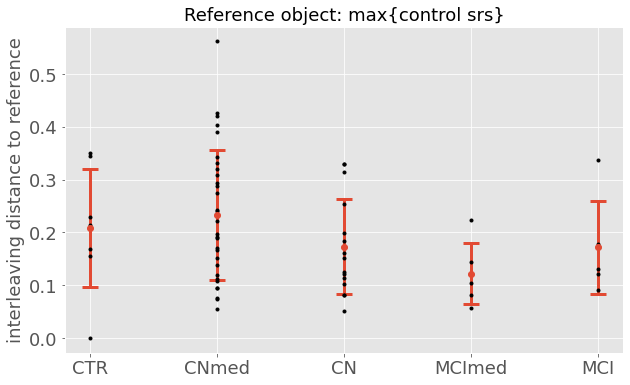

In [68]:
start = 0
end = 1

innerProd = dict()
ip_ctr = []
ip_pd_cn_med = []
ip_pd_cn_nonMed = []
ip_pd_mci_med = []
ip_pd_mci_nonMed = []

for subject, stableR in hsr_subjects.items():
    innerProd[subject] = stableR.interleaving_distance(ref)

    if labels[subject] == "CTR":
        ip_ctr.append(innerProd[subject])
    if labels[subject] == "PD_CN_med":
        ip_pd_cn_med.append(innerProd[subject])
    if labels[subject] == "PD_CN_nonMed":
        ip_pd_cn_nonMed.append(innerProd[subject])
    if labels[subject] == "PD_MCI_med":
        ip_pd_mci_med.append(innerProd[subject])
    if labels[subject] == "PD_MCI_nonMed":
        ip_pd_mci_nonMed.append(innerProd[subject])

class_means = [np.mean(np.array(ip_ctr)), np.mean(np.array(ip_pd_cn_med)), np.mean(np.array(ip_pd_cn_nonMed)), 
               np.mean(np.array(ip_pd_mci_med)), np.mean(np.array(ip_pd_mci_nonMed))]
class_stds = [np.std(np.array(ip_ctr)), np.std(np.array(ip_pd_cn_med)), np.mean(np.std(ip_pd_cn_nonMed)), 
               np.std(np.array(ip_pd_mci_med)), np.std(np.array(ip_pd_mci_nonMed))]

plt.figure(figsize=(10, 6))
plt.errorbar(x = [1, 2, 3, 4, 5], y = class_means, yerr = class_stds, fmt = "o", markersize = 6, capsize = 8, capthick = 3, elinewidth = 3)
plt.plot([1 for i in range(len(ip_ctr))], ip_ctr, ".k")
plt.plot([2 for i in range(len(ip_pd_cn_med))], ip_pd_cn_med, ".k")
plt.plot([3 for i in range(len(ip_pd_cn_nonMed))], ip_pd_cn_nonMed, ".k")
plt.plot([4 for i in range(len(ip_pd_mci_med))], ip_pd_mci_med, ".k")
plt.plot([5 for i in range(len(ip_pd_mci_nonMed))], ip_pd_mci_nonMed, ".k")
plt.xticks([1, 2, 3, 4, 5], ["CTR", "CNmed", "CN", "MCImed", "MCI"], fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel("interleaving distance to reference", fontsize = 18)
plt.title("Reference object: max{control srs}", fontsize = 18)
plt.show()
plt.close()

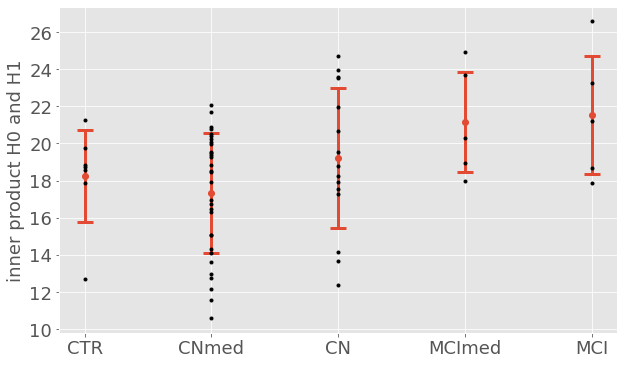

In [80]:
start = 0
end = 1

innerProd = dict()
ip_ctr = []
ip_pd_cn_med = []
ip_pd_cn_nonMed = []
ip_pd_mci_med = []
ip_pd_mci_nonMed = []

for subject in train_subjects:
    innerProd[subject] = hsr_subjects[subject].lp_distance(hsr_subjects_H1[subject], p = 2, start = 0, end = 1)

    if labels[subject] == "CTR":
        ip_ctr.append(innerProd[subject])
    if labels[subject] == "PD_CN_med":
        ip_pd_cn_med.append(innerProd[subject])
    if labels[subject] == "PD_CN_nonMed":
        ip_pd_cn_nonMed.append(innerProd[subject])
    if labels[subject] == "PD_MCI_med":
        ip_pd_mci_med.append(innerProd[subject])
    if labels[subject] == "PD_MCI_nonMed":
        ip_pd_mci_nonMed.append(innerProd[subject])

class_means = [np.mean(np.array(ip_ctr)), np.mean(np.array(ip_pd_cn_med)), np.mean(np.array(ip_pd_cn_nonMed)), 
               np.mean(np.array(ip_pd_mci_med)), np.mean(np.array(ip_pd_mci_nonMed))]
class_stds = [np.std(np.array(ip_ctr)), np.std(np.array(ip_pd_cn_med)), np.mean(np.std(ip_pd_cn_nonMed)), 
               np.std(np.array(ip_pd_mci_med)), np.std(np.array(ip_pd_mci_nonMed))]

plt.figure(figsize=(10, 6))
plt.errorbar(x = [1, 2, 3, 4, 5], y = class_means, yerr = class_stds, fmt = "o", markersize = 6, capsize = 8, capthick = 3, elinewidth = 3)
plt.plot([1 for i in range(len(ip_ctr))], ip_ctr, ".k")
plt.plot([2 for i in range(len(ip_pd_cn_med))], ip_pd_cn_med, ".k")
plt.plot([3 for i in range(len(ip_pd_cn_nonMed))], ip_pd_cn_nonMed, ".k")
plt.plot([4 for i in range(len(ip_pd_mci_med))], ip_pd_mci_med, ".k")
plt.plot([5 for i in range(len(ip_pd_mci_nonMed))], ip_pd_mci_nonMed, ".k")
plt.xticks([1, 2, 3, 4, 5], ["CTR", "CNmed", "CN", "MCImed", "MCI"], fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel("inner product H0 and H1", fontsize = 18)
plt.title("", fontsize = 18)
plt.show()
plt.close()

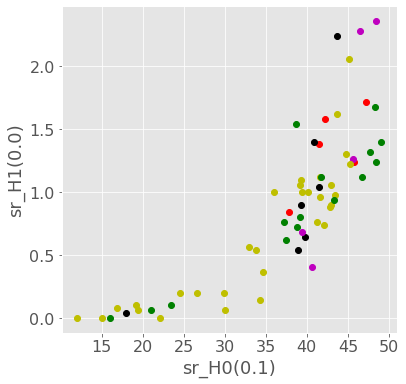

In [81]:
a = 0.1
b = 0.01
plt.figure(figsize=(6, 6))
plt.xlabel("sr_H0(" + str(np.round(a, 1)) + ")", fontsize = 18)
plt.ylabel("sr_H1(" + str(np.round(b, 1)) + ")", fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
for subject in train_subjects:
    xx = hsr_subjects[subject].evaluate(a)
    yy = hsr_subjects_H1[subject].evaluate(b)
    plt.plot(xx, yy, "o", color = colors[subject])

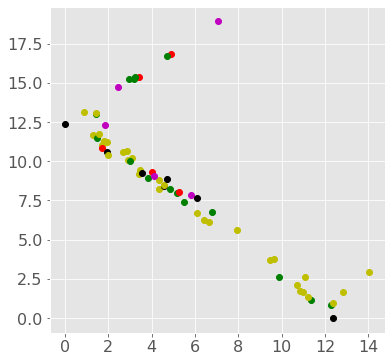

In [36]:
plt.figure(figsize=(6, 6))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
for subject, stableR in hsr_subjects.items():
    xx = stableR.lp_distance(max_sr_ctr, p = 2, start=start, end=end)
    yy = stableR.lp_distance(min_sr_ctr, p = 2, start=start, end=end)
    plt.plot(xx, yy, "o", color = colors[subject])

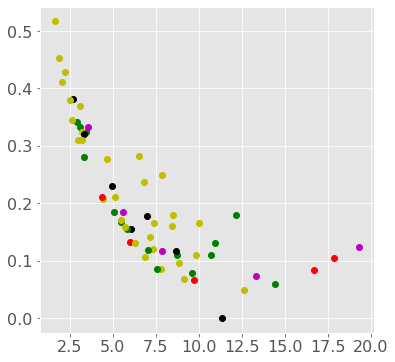

In [49]:
plt.figure(figsize=(6, 6))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
for subject, stableR in hsr_subjects.items():
    xx = stableR.evaluate(0.4)
    yy = stableR.interleaving_distance(max_sr_ctr) #, p = 2, start=start, end=end)
    plt.plot(xx, yy, "o", color = colors[subject])

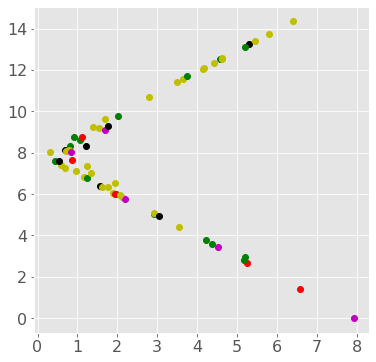

In [14]:
plt.figure(figsize=(6, 6))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
for subject, stableR in hsr_subjects.items():
    xx = stableR.lp_distance(total, start=start, end=end)
    yy = stableR.lp_distance(max_sr, start=start, end=end)
    plt.plot(xx, yy, "o", color = colors[subject])

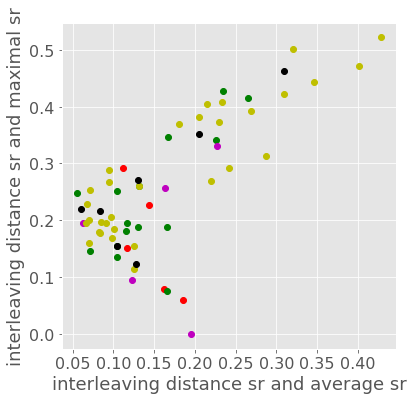

In [15]:
plt.figure(figsize=(6, 6))
plt.xlabel("interleaving distance sr and average sr", fontsize = 18)
plt.ylabel("interleaving distance sr and maximal sr", fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
for subject, stableR in hsr_subjects.items():
    xx = stableR.interleaving_distance(total)
    yy = stableR.interleaving_distance(max_sr)
    plt.plot(xx, yy, "o", color = colors[subject])

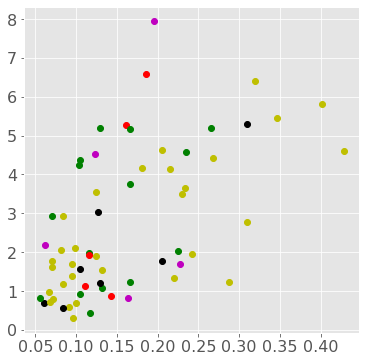

In [16]:
plt.figure(figsize=(6, 6))
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
for subject, stableR in hsr_subjects.items():
    xx = stableR.interleaving_distance(total)
    yy = stableR.lp_distance(total, start=start, end=end)
    plt.plot(xx, yy, "o", color = colors[subject])

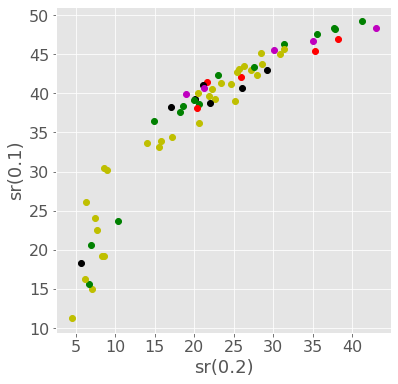

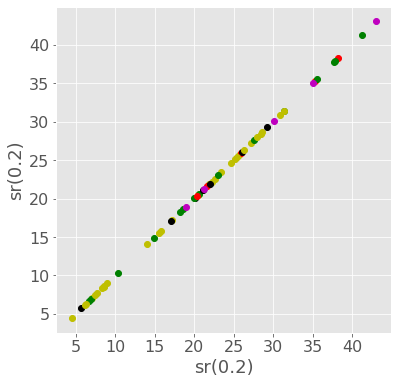

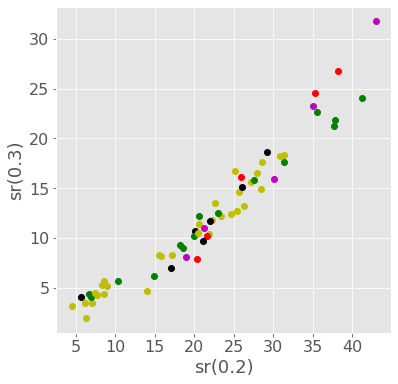

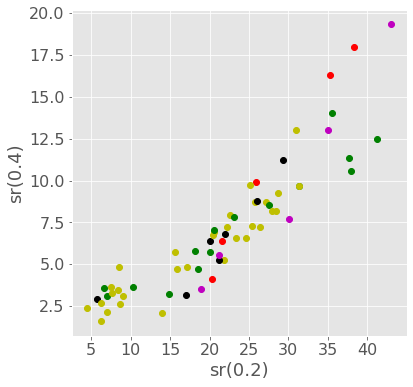

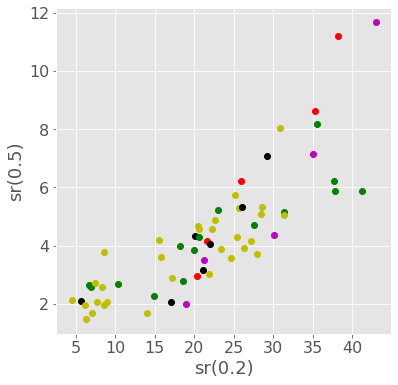

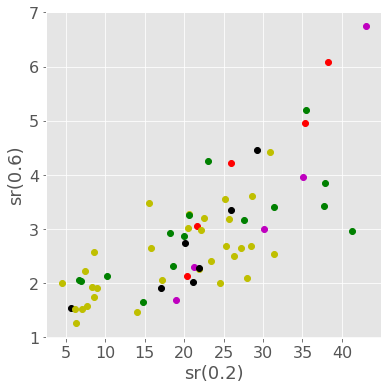

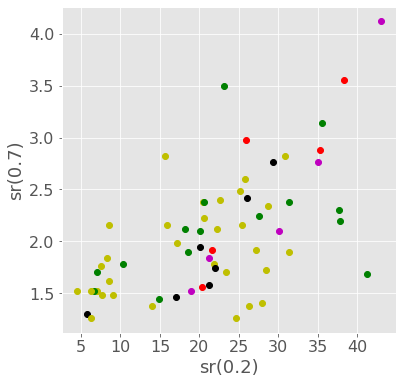

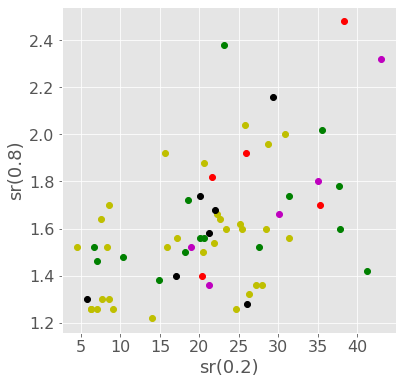

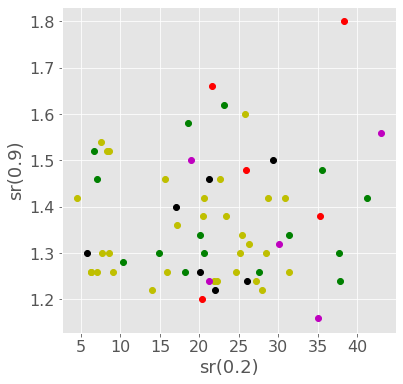

In [69]:
a = 0.2
for b in [0.1*k for k in range(1, 10)]:
    plt.figure(figsize=(6, 6))
    plt.xlabel("sr(" + str(np.round(a, 1)) + ")", fontsize = 18)
    plt.ylabel("sr(" + str(np.round(b, 1)) + ")", fontsize = 18)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    for subject, stableR in hsr_subjects.items():
        xx = stableR.evaluate(a)
        yy = stableR.evaluate(b)
        plt.plot(xx, yy, "o", color = colors[subject])
    plt.show()
    plt.close()